Bilimsel Programlama'ya Kolay Başlangıç serisinin [ilk yazısında](https://www.veridefteri.com/2018/08/29/bilimsel-programlamaya-kolay-baslangic-1/) Hazırlık, Hesaplama ve Sonuçları Görselleştirme adımlarından bahsetmiş ve bunları serbest düşüş problemine uygulamıştık. [İkinci yazıda](http://www.veridefteri.com/2018/09/03/bilimsel-programlamaya-kolay-baslangic-2/) ise Hesaplama adımından sonra Veri/Hata Analizi adımını eklemiş ve eğik atış problemini Euler sayısal metodu ile de hesaplayarak hatamızı incelemiştik. Lakin tüm bunları Python'un kendi matematik kütüphanesi olan `math` ile gerçekleştirdik.

Serinin üçüncü yazısında ise `math`'a oranla (genellikle) daha hızlı ve çok daha yetenekli olan `numpy` ve sonrasında da bunun üstüne bir kat daha çıkarak `scipy` kütüphanelerine terfi edeceğiz ve kolay yoldan bir ikinci derece diferansiyel denklem çözeceğiz. Bunun için Eğik Atış problemi yerine, nonlineer bir problem olan "iki cisim problemini", yani Dünya'nın çevresindeki uyduların dinamiğini kullanacağız.

İki cisim problemi en genel haliyle kütle çekiminden kaynaklanan ivmeden ibaret:

$$\ddot{\vec{r}} = - \frac{\mu}{r^3} \vec{r} $$

Burada $\vec{r}$ konum vektörünü, $r$ konum vektörünün büyüklüğünü ve $ \ddot{\vec{r}} $ konum vektörünün zamana göre ikinci türevini, ya da daha bilindik adıyla _ivmeyi_ gösteriyor. $\mu$ ise pek tanıdık değil, ama aslında Dünya'nın kütleçekim sabitini gösteriyor. Örneğin Ay'ın ya da bir uydunun, Dünya'nın çevresinde dönerken gelecekteki konum ve hızını bulabilmek için, başlangıçtaki konum ve hızı bu ivmenin integralini alarak ilerleteceğiz. İntegral lafını duyunca tüyleriniz diken diken olduysa korkmayın; integrali biz almayacağız, _bilgisayar_ alacak. 

Matematiğe gelmeden önce, işin kalbindeki veri yapısı olan `ZamanKonumHız` sınıfının `numpy` kullanan yeni sürümüne bakalım:

In [18]:
# sonradan gerekecek kütüphaneleri çağır
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Kütleçekimi Sabiti [m^3/s^2]
muDünya = 398600.5*1E9    

class ZamanKonumHız:
   """
    Zaman, 2D konum ve 2D hız değerlerini içeren vektör sınıfı
   """
   t = 0
   r = np.zeros(2)
   v = np.zeros(2)

   def __init__(self, t0, rx0, ry0, vx0, vy0):
       """
       Zaman, konum ve hızı ilk değerleriyle başlatır.
       
       Arguments:
           t0  {float} -- zaman (s)
           rx0 {float} -- x ekseninde konum (m)
           ry0 {float} -- y ekseninde konum (m)
           vx0 {float} -- x ekseninde hız (m/s)
           vy0 {float} -- y ekseninde hız (m/s)
      """
       self.t = t0      
       self.r = np.array([rx0, ry0])
       self.v = np.array([vx0, vy0])

      
   def konumBüyüklüğü(self):
       """Konum vektörünün büyüklüğünü döndürür
               
        Returns:
           float -- Konum vektörünün büyüklüğü ($m$)
       """
       return np.linalg.norm(self.r)

   def hızBüyüklüğü(self):
       """Hız vektörünün büyüklüğünü döndürür
        
        Returns:
           float -- Hız vektörünün büyüklüğü ($m^2/s^2$)
        """
       return np.linalg.norm(self.v)

   def spesifikEnerji(self):
       """
       Spesifik enerjiyi hesaplar.

       Spesifik enerji birim kütleye düşen enerji olarak tanımlanır

       $e =  \frac{1}{2} v^2 - \frac{\mu}{r} $
       
       Returns:
           float -- spesifik enerji ($m^2/s^2$)
       """
       return 0.5*self.v.dot(self.v) - muDünya/self.konumBüyüklüğü()

   def ivme (self, mu=muDünya):
       """
       İvmeyi hesaplar
       
       İki cisim problemine göre bu konum ve hıza ait ivmeyi hesaplar.
       
       Keyword Arguments:
           mu {float} -- Kütleçekimi Sabiti (m^3/s^2) (default: {muDünya})
       
       Returns:
           {ndarray} -- İvme vektörü ($m/s^2$)
       """
       return -mu/np.power(self.konumBüyüklüğü(), 3) * self.r

Öncelikle, eğik atış problemindeki sınıfa göre ne kadar az şeyin değiştiğine dikkatinizi çekmek isterim. İyi bir sınıf tasarımı sayesinde, çok daha başka bir problemde bile eski veri yapılarımızı kullanmayı başardık.

`numpy`'a geçişte konum ve hız vektörleri olan `r` ve `v`'yi minik ikili array'ler haline getirdik. Bu durum okunaklılığı kaçınılmaz olarak azaltıyor (`ry` mi daha açık, `r[1]` mi?), ama bize `numpy`'ın kuvvetli vektör işlemlerinin kapılarını açtığı için sonuçta çok faydalı.

Bununla birlikte, `__init__` vektörü hala `t0, rx0, ry0, vx0, vy0` değişkenlerini tek tek girmemizi istiyor. Bunları neden vektör olarak vermiyoruz diye merak edebilirsiniz. Bunu yapabiliriz, ama o zaman girdideki her bir vektörün iki elemanlı olduğunu kontrol etmemiz, sonra da ikiden fazla ya da eksik eleman çıkarsa ne yapacağımıza karar vermemiz gerekli. Bu nedenle, daha kodu yazarken, bu tür girdilerde ve arayüzlerde yapılabilecek hataları öngörüp buna göre önlem almak orta vadede sizi (ve kodlarınızı kullanacak başka kişileri) hatadan korur. Bu örnekte, bu sınıfı kullanacak kişileri doğru sayıda veri vermeye zorlayarak sınıfın hatalı şekilde başlatılmasının önüne geçtik. 

Bunun yanı sıra vektör büyüklüklerini hesaplama işini de `numpy`'ın `linalg.norm` metoduna emanet ettik. Böylece, örneğin bu sınıfı başka bir zaman 3 boyut için kullanmak istediğimizde bu kısımları değiştirmemiz gerekmeyecek, şimdiden hazırız.

Bu arada yorumları daha detaylı yazmaya başladık ve parametrelerin birimlerini de özellikle belirttik. Birimler ve arayüzler mühim, 1999 yılında Mars Climate Orbiter tam da bu yüzden [kaybedildi](https://www.wired.com/2010/11/1110mars-climate-observer-report/)!

Eklediğimiz `ivme` metodu da dikkatli gözlerden kaçmamıştır. Böylece ivme hesaplamasını `ZamanKonumHız` sınıfının bir yeteneği olarak tanımladık.

Son olarak `spesifikEnerji` adlı bir metod da ekledik. Spesifik enerji birim kütleye düşen enerji olarak tanımlanabilir:   
$e =  \frac{E}{m} = \frac{1}{2} v^2 - \frac{\mu}{r}$

Spesifik enerjinin bizim için önemi şurada: _İki cisim probleminde enerjinin korunup korunmadığına bakarak hatamızı kontrol edebiliriz_. Zira fizik bize enerjinin korunması gerektiğini söylüyor, enerji korunumundan ne kadar uzaklaşırsak yaptığımız hata da o kadar artmış demektir. Bunu da birazdan kullanacağız. 

Bu sınıfı uzun uzadıya anlattığım için şimdiden sıkılmaya başlayan arkadaşlara not: Genellikle bilimsel programlamada bu tarz temel veri yapılarını içeren sınıflar çok kullanılır. Bunları ne kadar özenle hazırlar ve yetenekler kazandırırsanız ileride hayatınız o kadar kolaylaşır.

Hazırlık kısmının diğer bileşenleri ise geçen yazıdan tanıdık gelecektir:

In [19]:
# Kütleçekimi Sabiti [m^3/s^2]
muDünya = 398600.5*1E9

# başlangıç zamanı
t0 = 0
# bitiş zamanı (sn)
tSon = 6000 
# adım büyüklüğü (sn)
tAdım = 5

# başlangıç konum ve hız
pvt0 = ZamanKonumHız(t0, 0, 7000*1E3, 7.5*1E3, 0)

İşin matematik kısmını bu örnekte fonkisyonlara toplayacağız. Bu tür fonksiyonlar ve bu fonksiyonları çağıran daha da başka fonksiyonlar [Matruşka Bebekleri](https://en.0wikipedia.org/wiki/Matryoshka_doll) gibi iç içe geçerek kodun çok daha derli toplu ve daha önemlisi _yeniden kullanılabilir_ olmasını sağlıyorlar. Aynı kodları defalarca yazmak hem zahmetli hem de hata bulma ve yeni işlev eklemeyi son derece zorlaştırıyor.

Bir sonraki adımda, bir önceki yazıda değndiğimiz temel fonksiyonları da `numpy` ile tekrar yazacağız. Yorumlar daha detaylı hale geldi, artık veri tipi bile yazıyor ama temel yapı aynı.

In [20]:
def eulerZamanKonumHız(dt, pvt, mu=muDünya):
    """
    Verilen bir dt adım büyüklüğü kadar zaman konum ve hızı Euler Metodu ile ilerletir.
    
    Arguments:
        dt {float} -- adım büyüklüğü (s)
        pvt {ZamanKonumHız} -- t zamanında zaman konum hız
        mu {float} -- Kütleçekimi Sabiti (m^3/s^2) (default: {muDünya})

    Returns:
        {ZamanKonumHız} -- t+dt zamanında zaman konum hız
    """
    a = pvt.ivme(mu)

    tYeni  = pvt.t + dt
    rYeni  = pvt.r + pvt.v * dt
    vYeni  = pvt.v + a * dt

    return ZamanKonumHız(tYeni, rYeni[0], rYeni[1], vYeni[0], vYeni[1])


def hesapDöngüsüEuler(pvt0, tAdım, tSon):
    """
    Euler sayısal integrasyon metoduyla konum ve hız değerleri listesini hesaplar.

    Arguments:
        tAdım {float} -- adım büyüklüğü (s)
        pvt0 {ZamanKonumHız} -- başlangıç zamanında zaman konum hız
        tSon {float} -- bitiş zamanı (s)

    Returns:
        list {ZamanKonumHız} --  her bir zaman adımı için zaman konum hız değerlerini içeren liste
    """
    # ilk değerleri doldur
    numPvtList = [pvt0]

    t = numPvtList[0].t + tAdım
    while t<=tSon:
        pvtNum = eulerZamanKonumHız(tAdım, numPvtList[-1])
        numPvtList.append( pvtNum )

        t += tAdım
    
    return (numPvtList)

`eulerZamanKonumHız` adlı yapı içinde iki cisim problemine ait ivmeyi hesaplıyoruz. Sonra da konumu bilinen en son hızı sabit kabul ederek, hızı da hesaplanan ivmeyi sabit kabul ederek ilerletiyoruz. Burada yaptığımız şey aslında _kısa bir zaman adımı için_ integral almak, ama bunu _sayısal_ olarak yaptığımız için son derece kolay şekilde hallediyoruz. Tabii ödediğimiz bedel "tam olarak doğru ve hatasız" değil, ancak yaklaşık bir hesaplama yapmak. `hesapDöngüsüEuler` adımı içinde ise bu küçük zaman adımlarını bir döngü içinde defalarca hesaplayarak `tSon` değerine kadar tüm konum ve hız çiftlerini elde ediyoruz.

Bütün matematiği yukarıda anlatılan fonkisyonlara paketlediğimiz için asıl işi yapacak kod sadece ve sadece 1 (bir) satıra indi:

In [21]:
# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList = hesapDöngüsüEuler(pvt0, tAdım, tSon)

Bu çok klasik bir "işi fonksiyonda yap, `return` ile sonucu döndür ve bu sonucu bir değişkene ata" diyebileceğim (muhtemelen birilerinin çoktan bir _pattern_ adı ile tanımladığı) bir yapı. Başkalarının kodlarını incelerken sıkça karşınıza çıkacak, sonra siz de bol bol kullanacaksınız.

Konum ve hız grafiklerine bakalım:

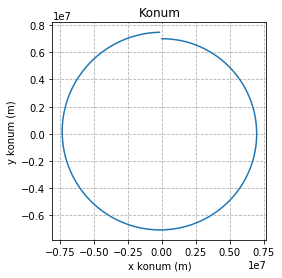

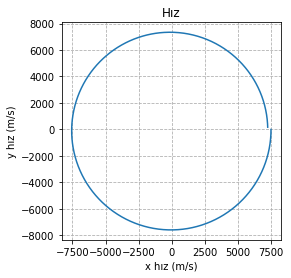

In [22]:
# konum grafiği 
plt.plot( [pvt.r[0] for pvt in eulPvtList], [pvt.r[1] for pvt in eulPvtList], label="Euler (" + str(tAdım) + " s)")

plt.title("Konum")
plt.xlabel("x konum (m)")
plt.ylabel('y konum (m)')

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

# hız grafiği
plt.plot( [pvt.v[0] for pvt in eulPvtList], [pvt.v[1] for pvt in eulPvtList], label="Euler (" + str(tAdım) + " s)")

plt.title("Hız")
plt.xlabel("x hız (m/s)")
plt.ylabel("y hız (m/s)")

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

Grafikleri oluşturduğumuz kod [bir önceki yazıdakinden](http://www.veridefteri.com/2018/09/03/bilimsel-programlamaya-kolay-baslangic-2/) pek farklı değil, ama eklediğimiz iki satırla eksenlerin ölçeklerini birbirine eşitlediğimize dikkat edin. Böylece daha gerçekçi bir fiziksel gösterim elde ettik.


Grafiklere yakından bakınca bir tuhaflık göze çarpıyor: ilk grafikte "saat 12" konumundan başlayıp saat yönünde dönüyoruz, ama başladığımız yere geri dönemiyoruz. Aynı durum hız için de geçerli. Normalde iki cisim problemi _periyodik_ bir problem, enerji korunuyor ve bu nedenle de -gördüğümüz grafiklerin aksine- başladığımız konum ve hıza geri dönmeyi bekliyoruz. Diğer bir deyişle, potansiyel ve kinetik enerjinin toplamının değişmemesi gerekiyor. Bizim çözümümüzde enerjinin korunup korunmadığını test etmek için, başlangıç konum ve hızından hesapladığımız "referans" enerji değerinden, her yeni zaman için ne kadar sapıldığını kontrol etmemiz yeterli:

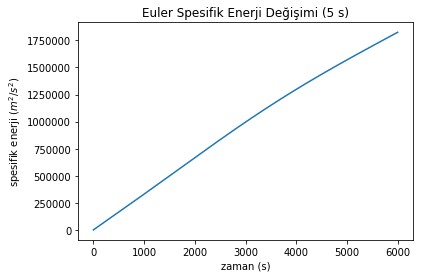

In [23]:
# enerji grafikleri

#referans değer - tüm farklar bu değere göre hesaplanacak
spEnerjiRef = pvt0.spesifikEnerji()

plt.title("Euler Spesifik Enerji Değişimi (" + str(tAdım) + " s)")
plt.xlabel("zaman (s)")
plt.ylabel(r"spesifik enerji ($m^2/s^2$)")

plt.plot( [pvt.t for pvt in eulPvtList], [pvt.spesifikEnerji()-spEnerjiRef for pvt in eulPvtList], label="Euler (" + str(tAdım) + " s)")

plt.show()

Görünüşe göre spesifik enerji lineer olarak artıyor ve bu artış duracakmış gibi de görünmüyor. Anlaşılan o ki, Euler ilerleticisi _enerjiyi korumuyor_. Adım büyüklüğünü azaltırsak hatanın da azalacağından daha önce bahsetmiştik. O halde 1, 5 ve 10 saniye için duruma bir göz atalım:

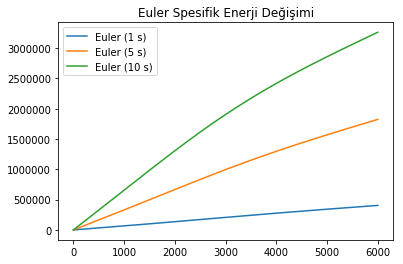

In [24]:
# adım büyüklüğü (sn)
tAdım5  = 5
tAdım10 = 10
tAdım1  = 1

# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList5  = hesapDöngüsüEuler(pvt0, tAdım5, tSon)
eulPvtList10 = hesapDöngüsüEuler(pvt0, tAdım10, tSon)
eulPvtList1  = hesapDöngüsüEuler(pvt0, tAdım1, tSon)

# enerji grafikleri

plt.title("Euler Spesifik Enerji Değişimi")

plt.plot( [pvt.t for pvt in eulPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList1], label="Euler (" + str(tAdım1) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList5], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList5], label="Euler (" + str(tAdım5) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList10], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList10], label="Euler (" + str(tAdım10) + " s)")

plt.legend(loc=2)

plt.show()

Gerçekten de, adım büyüklüğü azaldıkça enerjideki artış yavaşlıyor. Yani adım büyüklüğünü ne kadar azaltırsak enerjinin korunumuna o oranda yaklaşıyoruz, haliyle konum ve hız hatamız da azalıyor. Teorik olarak, adım büyüklüğü sıfıra giderken enerji hatamızı da sıfırlayabiliriz! Gerçekte, başımıza dert olan kayan nokta hataları nedeniyle hatayı belli bir değerin altına indirmek mümkün değil.

Bu da sayısal modellerin, neden gerçek matematiksel modellerin yerini almakta zorlanacağını bize anlatıyor - tam matematiksel modeli elde edilemeyen, diferansiyel denklemi çözülemeyen ağır problemleri tenzih ediyorum elbette. Zira Euler ya da Runge-Kutta gibi matematiksel modeller fiziksel gerçekliği değil, sadece _problemin fiziğini ifade eden diferansiyel denklemlerin çözümünü_ modellemeye yarıyor. Enerjinin ya da momentumun korunumunu da modellemek için, bunun için özelleşmiş matematiksel modeller gerekiyor.

İşin yazılım tarafına baktığınızda ise, bu tür testlerle modellerinizin doğruluğunu ve nasıl davrandığını, istediğiniz doğruluğa ulaşmak için adım büyüklüğünü nasıl seçmeniz gerektiğini kestirebilirsiniz. Ya da enerjinin korunumu en ufak sorunda bozulan hassas bir denge olduğu için, sayısal integrasyon algoritmanıza bir _modül testi_ olarak yazabilirsiniz. İşler yeterince büyüdüğünde, yazılımınızın bir köşesinde bir şeyleri değiştirirken başka bir köşesinde bir şeyleri kırıp dökmek çok kolay olduğu için, bu tür testleri yazıp düzenli olarak çalıştırdığınızda yaptığınız hangi değişikliğin ortalığı karıştırdığını bulmak çok kolay olacaktır.

Buraya kadar `numpy` kullanımına basit bir giriş yaptık. Daha ileri matematiksel yöntemler de var. Bunları `numpy` ile hazırlamak mümkün olsa da, `scipy` kütüphanesi daha geniş imkanlar sağlıyor. Bunları [bir sonraki kısımda](http://www.veridefteri.com/2019/03/02/bilimsel-programlamaya-kolay-baslangic-iv/) göreceğiz.